<a href="https://colab.research.google.com/github/ARMargolis/melanoma-pytorch/blob/master/flowers_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [28]:
# If this code gives an error, open a flower notebook and run 
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
# print(GCS_DS_PATH)
GCS_DS_PATH =r'gs://kds-752f9da513db142ac27a6ea4f8367cf796b314d58c3786ab37bec03a'

IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 12
BATCH_SIZE = 16 #Using GPU
#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
#TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [29]:
import re, numpy as np

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    #dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048, seed=42)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
#NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
#STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 12753 training images, 3712 validation images


In [30]:
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
import torch
from torch import nn, sigmoid
from torch.nn import functional as F
from torch.utils import data
from torch.optim import Adam

from PIL import Image, ImageOps
from torchvision import transforms, utils

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

class flowerDataSet(data.Dataset):
    # TODO initialize conv layers and fc layers in a particular way. Important for our experiment
    # TODO add cuda support
    
    def __init__(self, gcs_path, train, device = default_device, transform=None):
        """
        Initializes the dataset. Will use .tfrec files
        gcs_path (str): GCS path where images and labels are stored
        specifications (optional): any extra keyword args are stored in a dict. Can include:
            -transform
            -resolution: what size do we want to resize the images to? Square or rectangular?
        """
        
        self.train=train
        if transform:
          self.transform=transform
        else:
          self.transform=transforms.ToTensor()

        self.gcs_path = gcs_path
        tfrec_dataset = tf.data.TFRecordDataset(gcs_path)
        tfrec_dataset_cache=tfrec_dataset.cache()
        if self.train:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(read_labeled_tfrecord)
        else:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(read_unlabeled_tfrecord)
        self.data_iter=tfrec_dataset_cache_map1.as_numpy_iterator()
        self.label_df=pd.Series(tf.io.gfile.glob(gcs_path))

        self.device = device
    
    def __len__(self):
        return self.label_df.shape[0]

    def __getitem__(self, idx):
        """
            Get a single sample
            Want this method to be very fast, i.e. few or no if statements, etc.
        """
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        
        next_data=next(self.data_iter)
        img=self.transform(Image.fromarray((next_data[0]* 255).astype(np.uint8)))
        return img, torch.tensor(next_data[1], dtype=torch.long)

        # get PIL image
        #decoded_img=decode_image(next_data[0])
        #decoded_img=decode_image(next_data[0].astype(np.uint8)).numpy().astype(np.uint8)
        #image = Image.fromarray(decoded_img)
        #image = self.transform(image)
        #image = image.to(self.device)

        #if self.train: #Include the label if it's training data
          #label=next_data[1]
          #return (image, torch.LongTensor([label]))
        #return (image, next_data[1])

    def display_sample(self, idx):
        pic, label = self.__getitem__(idx)
        #pic = pic.to('cpu')
        pic = transforms.functional.to_pil_image(pic)
        print(CLASSES[label])
        # if not using in jupyter notebook context, show the image directly instead of returning it
        # pic.show()
        return pic

In [31]:
transform=transforms.Compose(
                    [
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.RandomCrop((224,224)),
                        transforms.ToTensor()
                    ])
IMAGE_SIZE=[512,512]
train_data = flowerDataSet(gcs_path=TRAINING_FILENAMES, train = True, transform=transform)

snapdragon


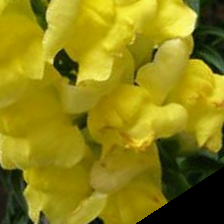

In [11]:
train_data.display_sample(0)

In [62]:
import torchvision.models as models
model = models.resnet18(pretrained = True)

In [63]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 

In [64]:
from collections import OrderedDict

#Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

model.to(default_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Begin Sat Aug 22 09:16:20 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/5.. Training Loss: 0.40220023121336884 Validation Loss: 0.2767069686268424 Sat Aug 22 09:26:13 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/5.. Training Loss: 0.3111593675344194 Validation Loss: 0.24104883795571996 Sat Aug 22 09:36:05 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/5.. Training Loss: 0.2898682752403756 Validation Loss: 0.2343197589948902 Sat Aug 22 09:45:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/5.. Training Loss: 0.2792676058828265 Validation Loss: 0.22343220619950444 Sat Aug 22 09:55:46 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 5/5.. Training Loss: 0.2742460059211047 Validation Loss: 0.22371574435061936 Sat Aug 22 10:05:35 2020


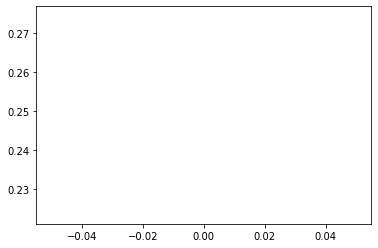

In [65]:
from torch import nn
from torch import optim
from time import ctime
import matplotlib.pyplot as plt
from torchvision import transforms

#function to train the model
def train_validate(model, train_names, val_names, criterion, optimizer, epochs = 5, BATCH_SIZE=8,
                   t_transform=None, v_transform=None):
    print('Begin', ctime())
    for e in range(epochs):
      train_data = flowerDataSet(gcs_path=train_names, train = True, transform=t_transform)
      trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
      train_loss =[]
      val_loss=[]
      running_loss=0
      batch_num=0
      for s in range(NUM_TRAINING_IMAGES//BATCH_SIZE):
        for images, labels in trainloader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            batch_num+=1

            optimizer.zero_grad()
            img = model(inputs)
            loss = criterion(img, labels)
            running_loss+=loss.item()
            loss.backward()
            optimizer.step()
      train_loss.append(running_loss/NUM_TRAINING_IMAGES)
      print('Training Steps:', NUM_TRAINING_IMAGES//BATCH_SIZE, "Batches:", batch_num)
      running_loss=0
      batch_num=0
      val_data = flowerDataSet(gcs_path=val_names, train = True, transform=v_transform)
      val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=False)
      for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
          for images, labels in val_loader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            batch_num+=1

            img = model(inputs)
            loss = criterion(img, labels)
            running_loss+=loss.item()

      val_loss.append(running_loss/NUM_VALIDATION_IMAGES)
      print('Validation Steps:', NUM_VALIDATION_IMAGES//BATCH_SIZE, "Batches:", batch_num)
      print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss:", train_loss[-1],
         "Validation Loss:", val_loss[-1], ctime()) 
      torch.save(model.state_dict(), '/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(e))

    plt.plot(train_loss,label="Training Loss")
    plt.plot(val_loss,label="Validation Loss")
    plt.show() 
    
    
epochs = 5
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
t_transform=transforms.Compose(
                    [
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.RandomCrop((224,224)),
                        transforms.ToTensor()
                    ])
v_transform=transforms.Compose(
                    [
                        transforms.Resize((224,224)),
                        transforms.ToTensor()
                    ])
train_validate(model,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, epochs,
               t_transform=t_transform, v_transform=v_transform) 

In [80]:
list(model.modules())

[ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [70]:
import torch.nn.utils.prune as prune

def prune_network(model, proportion):
    for module in list(model.children()):
        if isinstance(module,nn.Conv2d) or isinstance(module, nn.Conv1d):
            # conv layer? -> Structured pruning of channels? or unstructured?
            # Below is prune based on l2 norm, by channel
            prune.ln_structured(module, name="weight", amount=proportion, n=2, dim=0)
            # For just unstructured pruning, uncomment the line below:
            #prune.l1_unstructured(module, "weight", proportion)
        elif isinstance(module,nn.Linear):
            # fc layer? -> prune all weights, unstructured
            prune.l1_unstructured(module, "weight", proportion)

---------------------
PRUNING ITERATION  0 Sat Aug 22 10:39:49 2020
Begin Sat Aug 22 10:39:49 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23439663671273153 Validation Loss: 0.18574086398464337 Sat Aug 22 10:50:04 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21333238965977241 Validation Loss: 0.17782435200883653 Sat Aug 22 11:00:12 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2047133770648857 Validation Loss: 0.17305360262378536 Sat Aug 22 11:10:20 2020


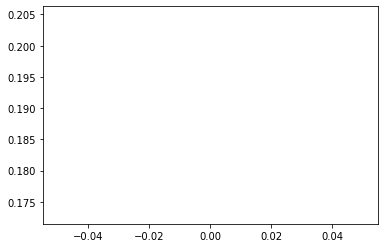

pruning network...
---------------------
PRUNING ITERATION  1 Sat Aug 22 11:10:21 2020
Begin Sat Aug 22 11:10:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2359795101944497 Validation Loss: 0.184582391107487 Sat Aug 22 11:20:34 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21511205948820902 Validation Loss: 0.17757945862831548 Sat Aug 22 11:30:44 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20483299340863775 Validation Loss: 0.17313412541989237 Sat Aug 22 11:40:52 2020


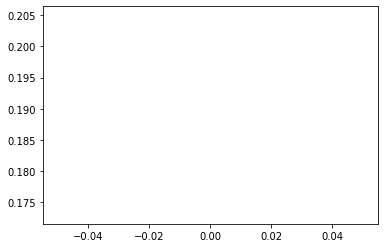

pruning network...
---------------------
PRUNING ITERATION  2 Sat Aug 22 11:40:52 2020
Begin Sat Aug 22 11:40:52 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23528698961435462 Validation Loss: 0.18722663076337556 Sat Aug 22 11:51:01 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21292004769155767 Validation Loss: 0.17947978697363928 Sat Aug 22 12:01:10 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20239574269674288 Validation Loss: 0.1729922605164606 Sat Aug 22 12:11:20 2020


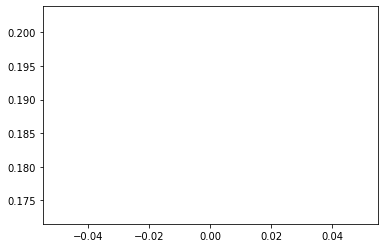

NameError: ignored

In [85]:
from torch import optim
learning_rate=.0002

repetitions = 3
j_epochs = 3
prune_proportion = 0.1
momentum = 0.5

network = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network.fc = fc

network.to(default_device)
initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(3))
#init the masks, etc. 
network.load_state_dict(initial_state_dict)
prune_network(network, 0.0)
#saved_val = initial_state_dict["conv1.weight_orig"].clone().detach()
# delete all the masks so that they are not loaded later
for k in initial_state_dict.copy():
    # detach the vars so they don't just change as the model trains
    initial_state_dict[k] = initial_state_dict[k].clone().detach()
    if "mask" in k:
        del initial_state_dict[k]


#torch.save(network.state_dict(), './pruning_examples/model.pth') # save the initial model + weights to the disk but also keep in memory



for rep in range(repetitions):
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("---------------------\nPRUNING ITERATION ",rep, ctime())
    train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)


---------------------
PRUNING ITERATION  3 Sat Aug 22 12:11:22 2020
Begin Sat Aug 22 12:11:22 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2348157466229089 Validation Loss: 0.18597956316079944 Sat Aug 22 12:21:41 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21276756803269462 Validation Loss: 0.17838272614131584 Sat Aug 22 12:32:01 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20359168040615003 Validation Loss: 0.1733447734210319 Sat Aug 22 12:42:16 2020


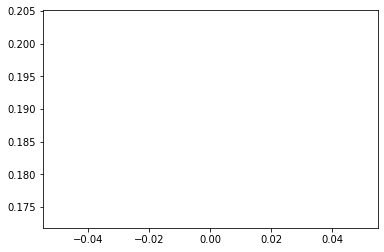

---------------------
PRUNING ITERATION  4 Sat Aug 22 12:42:16 2020
Begin Sat Aug 22 12:42:16 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2327055255847754 Validation Loss: 0.18638673016865706 Sat Aug 22 12:52:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21348536418838368 Validation Loss: 0.17852319575894368 Sat Aug 22 13:02:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20112350559123382 Validation Loss: 0.17231867862223038 Sat Aug 22 13:13:22 2020


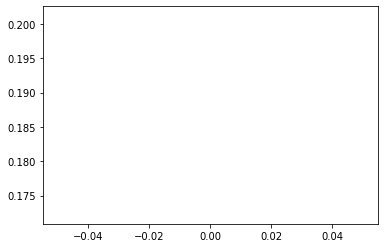

NameError: ignored

In [86]:
prune_proportion = 0.2

for rep in range(repetitions,5):
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("---------------------\nPRUNING ITERATION ",rep, ctime())
    train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)

torch.save(network.state_dict(), '/content/gdrive/My Drive/melanoma0817pruned.pth'.format(i))


In [87]:
torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0822pruned.pth')

In [ ]:
'''
val_loader = DataLoader(flower_val, batch_size = BATCH_SIZE, shuffle=False)
for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
    for images, labels in val_loader:
      inputs, labels = images.to(default_device), labels.to(default_device)
      inputs=inputs.permute(0,3,1,2)

      img = model(inputs)
      loss = criterion(img, labels)
      print(loss.item())
'''

In [ ]:
'''
flower_val = flowerDataSet(gcs_path=VALIDATION_FILENAMES, train = True)
flower_val_loader = DataLoader(flower_val, batch_size = 16, shuffle=False)
'''

In [ ]:
'''
def validate(model, trainloader, criterion, steps = 5):
    val_loss =[]
    for s in range(steps):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            inputs=inputs.permute(0,3,1,2)

            optimizer.zero_grad()
            img = model(inputs)
            print(inputs.dtype, labels.dtype, img.dtype)
            print(inputs.shape, labels.shape, img.shape)

            loss = criterion(img, labels)
            running_loss+=loss
        print("Epoch : {}/{}..".format(s+1,steps),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        val_loss.append(running_loss)
    plt.plot(val_loss,label="Training Loss")
    plt.show() 
    '''